# Reproducing MCCD's Experiments

In [93]:
import json
from functools import partial
from io import StringIO
from operator import itemgetter

from surface_sim.setups.setup import SetupDict

from mccd.random_clifford_circuit import *
from surface_sim.setups import CircuitNoiseSetup
from surface_sim.models import CircuitNoiseModel, BiasedCircuitNoiseModel
from surface_sim import Detectors, Setup
from surface_sim.experiments import schedule_from_circuit, experiment_from_schedule
import time
import stim
import torch

from pathlib import Path
import stim
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
from joblib import Parallel, delayed
import itertools
import shelve
from surface_sim.layouts import rot_surface_codes

from pymatching import Matching as MWPM
from mle_decoder import MLEDecoder as MLE
from stimbposd import BPOSD
from sklearn.metrics import accuracy_score

import torch
from mccd.dataset import *



## Baseline Decoders

- MWPM. We use the open-source library PyMatching with the noise model used for data generation as detailed in the ‘Experimentally motivated noise model’ subsection.

- BP-OSD. We use the open-source library stimbposd. We use the exact noise model used for data generation and set the maximal belief propagation iterations to 20.

- MLE. We use the algorithm developed and implemented as in ref. 14.

### Notes

All baselines have PyPI packages.

```
pymatching
mle-decoder
stimbposd
```

In [94]:
DECODER_BASELINES = {
    'BPOSD': partial(BPOSD, max_bp_iters=20),
    'MLE': MLE,
    'MWPM': MWPM,
}

## Basic Gates & Surface Code

MCCD uses I, X, Y, Z, H (single qubit gates) and CX (two qubit gates).

MCCD uses Rotated Surface Code.

surface-sim supports I, X, Z for rotated gates and I, H, X, Z for unrotated gates.

### Notes

We use the gates which `surface-sim` supports.

In [95]:
from surface_sim.circuit_blocks.rot_surface_code_css import gate_to_iterator
print('Rotated', gate_to_iterator.keys())
from surface_sim.circuit_blocks.unrot_surface_code_css import gate_to_iterator
print('Unrotated', gate_to_iterator.keys())
ROT_GATES = list('IXZ')
UNR_GATES = list('IHXZ')
MCCD_GATES = ['I', 'X', 'Y', 'Z', 'H']

Rotated dict_keys(['TICK', 'I', 'S', 'X', 'Z', 'CX', 'CNOT', 'R', 'RZ', 'RX', 'M', 'MZ', 'MX'])
Unrotated dict_keys(['TICK', 'I', 'S', 'H', 'X', 'Z', 'CX', 'CNOT', 'R', 'RZ', 'RX', 'M', 'MZ', 'MX'])


## Noise Model

1. The experimentally motivated noise model, which is the one used in all numerical results in the main text. See Methods section for details.
2. A simplified noise model that replaces all Pauli noise channels, both single-qubit and two-qubit, in the experiment-motivated noise model with a depolarizing noise model using an average noise strength. The probabilities of idling error, reset error, and measurement error remain the same. We refer to this as the average depolarizing noise model.
3. A stronger depolarizing noise model in which the strengths of all noise channels, including single- and two-qubit depolarization, idling error, reset error, and measurement error probability, are doubled compared to the average depolarizing noise model. We refer to this as the double depolarizing noise model.

### Note

1 can only be implemented with `stim`'s builtin instructions like `PAULI_CHANNEL_2` to fill all the parameters.
Or as a custom `Model` of `surface-sim`.

This noise model is used in Results (Fig. 4 & Fig. 5).

2 & 3 can be implemented with `surface-sim`'s `CircuitNoiseModel` with a single `prob` parameter.

The paper does not release the value of the average noise probability. We set it to 1e-3.

### Details of experimentally motivated noise model.

For the numerical studies presented in the ‘Results’ section, we use the stim package for simulation. We consider a circuit-level noise model motivated by the current experimental capability of neutral atom array-based quantum computers. Specifically, we use a circuit-level noise model that includes the following physical noises:

• Each two-qubit physical gate is followed by a two-qubit Pauli noise channel with probability [0.0005, 0.00175, 0.000625, 0.0005, 0, 0, 0, 0.00175, 0, 0, 0, 0.000625, 0, 0, 0.00125]

• Each single-qubit physical gate is followed by a single-qubit depolarizing model with probability [0.0001, 0.0001, 0.0001]

• On a physical level, the atoms are moved to achieve flexible connectivity between different physical qubits. This comes at the cost of having idling error due to the extra time taken during the physical qubit movement, which is captured as a Pauli noise channel with probability [4 × 10−7, 4 × 10−7, 1.6 × 10−6]. This error channel is applied when physical qubit movement happens.

• Resetting a physical qubit has a bit flip error probability of P = 0.002.

• Measuring a physical qubit has a bit flip error probability of P = 0.002.



In [96]:
from gensim.utils import grouper
from stim import CircuitInstruction, Circuit
from surface_sim.setups import SQ_GATES, TQ_GATES, SQ_MEASUREMENTS, SQ_RESETS
from typing import override, Collection
from surface_sim import Model


class ExperimentalCircuitNoiseModel(Model):
    @override
    def __getattribute__(self, name: str) -> object:
        attr = super().__getattribute__(name)

        if not callable(attr):
            return attr

        if name in SQ_GATES:

            def sq_gate(qubits: Collection[str]) -> Circuit:
                inds = self.get_inds(qubits)
                circ = Circuit()
                circ.append(CircuitInstruction(SQ_GATES[name], inds))
                circ.append(CircuitInstruction("PAULI_CHANNEL_1", inds, [0.0001, 0.0001, 0.0001]))
                return circ

            return sq_gate

        elif name in TQ_GATES:

            def tq_gate(qubits: Collection[str]) -> Circuit:
                if len(qubits) % 2 != 0:
                    raise ValueError("Expected and even number of qubits.")

                inds = self.get_inds(qubits)
                circ = Circuit()
                circ.append(CircuitInstruction(TQ_GATES[name], inds))
                probs = [0.0005, 0.00175, 0.000625, 0.0005, 0, 0, 0, 0.00175, 0, 0, 0, 0.000625, 0, 0, 0.00125]
                circ.append(CircuitInstruction("PAULI_CHANNEL_2", inds, probs))
                return circ

            return tq_gate

        elif name in SQ_MEASUREMENTS:

            def sq_meas(qubits: Collection[str]) -> Circuit:
                inds = self.get_inds(qubits)
                noise_name = "X_ERROR" if "_x" not in name else "Z_ERROR"
                circ = Circuit()

                # separates X_ERROR and MZ lines for clearer stim.Circuits and diagrams
                prob: float = 0.002
                circ.append(CircuitInstruction(noise_name, inds, [prob]))
                for qubit in qubits:
                    self.add_meas(qubit)

                return circ

            return sq_meas

        elif name in SQ_RESETS:

            def sq_reset(qubits: Collection[str]) -> Circuit:
                inds = self.get_inds(qubits)
                noise_name = "X_ERROR" if "_x" not in name else "Z_ERROR"
                circ = Circuit()
                circ.append(CircuitInstruction(SQ_RESETS[name], inds))
                prob: float = 0.002
                circ.append(CircuitInstruction(noise_name, inds, [prob]))
                return circ

            return sq_reset

        return attr

    @override
    def idle(self, qubits: Collection[str]) -> Circuit:
        inds = self.get_inds(qubits)
        circ = Circuit()

        circ.append(CircuitInstruction("I", inds))
        circ += self.idle_noise(qubits)

        return circ

    @override
    def idle_noise(
        self, qubits: Collection[str], param_name: str = "idle_error_prob"
    ) -> Circuit:
        # inds = self.get_inds(qubits)
        circ = Circuit()
        # TODO
        return circ

    @override
    def incoming_noise(self, qubits: Collection[str]) -> Circuit:
        return Circuit()


In [276]:
def to_stim_circuit(mccd_circuit, depth):
    """Convert a MCCD circuit to stimuli circuit
    Args:
        mccd_circuit: MCCD circuit

    Returns:
        A stimuli circuit
    """
    # 还是需要自己插入tick，否则只会有final round syndrome。
    # 然后num-detectors也不随着depth变化。这里插入一个tick会对应phy-cir里面的一块detector指令。

    res = stim.Circuit()
    # Must have R and M. Error inactive layout.
    for n in range(mccd_circuit.n_logical_qubits):
        res.append('R', [n])
    res.append('TICK') # After Reset all.

    ops_list = list(mccd_circuit)
    ops_num = len(ops_list)
    assert ops_num % 2 == 0, "The number of operations should be even for mirror symmetric circuits."
    ops_num_half = ops_num // 2

    current = 0
    for name, timestep, qubits in ops_list:
        if timestep != current:
            current = timestep
            res.append('TICK')
        res.append(name, qubits)

    # current = 0
    # for name, timestep, qubits in ops_list[ops_num_half:]:
    #     if timestep != current:
    #         current = timestep
    #         res.append('TICK')
    #     res.append(name, qubits)

    if res[-1].name != 'TICK':
        res.append('TICK') # Before Measure all.

    for n in range(mccd_circuit.n_logical_qubits):
        res.append('M', [n])

    return res

def print_random_circuit(c: RandomCliffordCircuit):
    return list(c)

def dict_product(input_dict):
    keys = input_dict.keys()
    value_lists = input_dict.values()

    # 使用itertools.product生成所有值的组合
    value_combinations = itertools.product(*value_lists)

    # 将每个值的组合与键配对，生成字典列表
    for combo in value_combinations:
        yield dict(zip(keys, combo))

def run_decoder(name: str, circuit: stim.Circuit, shots: int):
    """Runs decoder on the given circuit

    Args:
        name: decoder name
        circuit: circuit to run
        shots: number of shots

    Returns:
        A dict containing the decoder metrics.
    """
    method = DECODER_BASELINES[name](circuit.detector_error_model())
    sampler = circuit.compile_detector_sampler()
    syndrome, labels = sampler.sample(shots=shots, separate_observables=True)
    begin = time.time_ns()
    predictions = method.decode_batch(syndrome)
    end = time.time_ns()
    logical_accuracy = accuracy_score(labels, predictions)
    walltime_seconds = (end - begin) / 1e9
    return dict(
        decoder=name,
        logical_accuracy=logical_accuracy,
        walltime_seconds=walltime_seconds,
    )

def experimental_noise_model(*layouts):
    return ExperimentalCircuitNoiseModel.from_layouts(CircuitNoiseSetup(), *layouts)

def average_depolarizing_noise(*layouts, noise_prob=1e-3):
    setup = CircuitNoiseSetup()
    setup.set_var_param("prob", noise_prob)
    model = CircuitNoiseModel.from_layouts(setup, *layouts)
    return model

def double_depolarizing_noise(*layouts, noise_prob=1e-3):
    return average_depolarizing_noise(noise_prob * 2, *layouts)

def compile_to_physical(log_cir: stim.Circuit, distance: int, noise_model,
                        rotated=True) -> stim.Circuit:
    """Compile a logical circuit to physical one with the average depolarizing noise model.

    Args:
        log_cir: logical circuit
        distance: distance between qubits
        rotated: rotated code or unrotated code.
        noise_prob: average depolarizing noise probability

    Returns:
        The compiled logical circuit.
    """
    if rotated:
        from surface_sim.circuit_blocks.rot_surface_code_css import gate_to_iterator
        from surface_sim.layouts import rot_surface_codes
        layouts = rot_surface_codes(log_cir.num_qubits, distance=distance)
    else:
        from surface_sim.circuit_blocks.unrot_surface_code_css import gate_to_iterator
        from surface_sim.layouts import unrot_surface_codes
        layouts = unrot_surface_codes(log_cir.num_qubits, distance=distance)

    model = noise_model(*layouts)
    detectors = Detectors.from_layouts("pre-gate", *layouts)
    schedule = schedule_from_circuit(log_cir, layouts, gate_to_iterator)
    phy_cir: stim.Circuit = experiment_from_schedule(
        schedule, model, detectors, anc_reset=True
    )
    return phy_cir


def random_mirror_symmetric_clifford(circuit_index: str, depth: int,
                                     rotated=True) -> stim.Circuit:
    """Generate a random mirror symmetric clifford circuit (Type I or Type II)

    Args:
        circuit_index: circuit index
        depth: circuit depth before mirroring.
        rotated: rotated code or unrotated code.

    Returns:
        The generated clifford circuit
    """
    assert circuit_index in ['3', '4']
    logical_class = TypeICircuit if circuit_index == '3' else TypeIICircuit
    n_logical_qubits = 2

    random_circuit = logical_class(
        n_logical_qubits=n_logical_qubits,
        circuit_index=circuit_index,
        depth=depth,
        single_qubit_gate_list=ROT_GATES if rotated else ROT_GATES,
    )
    random_circuit.sample_circuit()
    return to_stim_circuit(random_circuit, depth=depth), random_circuit


def generate_circuit(distance: int, depth: int, circuit_index: str, noise_model):
    log_cir, _ = random_mirror_symmetric_clifford(circuit_index, depth)
    phy_cir: stim.Circuit = compile_to_physical(log_cir, distance, noise_model)
    num_detectors = phy_cir.num_detectors
    config = dict(distance=distance, depth=depth, circuit_type_index=circuit_index,
                  num_detectors=num_detectors, noise_model=noise_model.__name__,
                  num_ticks=log_cir.num_ticks)
    return phy_cir, log_cir, config


In [279]:
c1, c2 = random_mirror_symmetric_clifford('4', 2)

In [280]:
c1

stim.Circuit('''
    R 0 1
    TICK
    Z 0
    X 1
    TICK
    CX 1 0
    TICK
    Z 0
    X 1
    TICK
    CX 1 0
    TICK
    CX 1 0
    TICK
    Z 0
    X 1
    TICK
    CX 1 0
    TICK
    Z 0
    X 1
    TICK
    M 0 1
''')

In [281]:
list(c2)

[(np.str_('Z'), 0, [0]),
 (np.str_('X'), 0, [1]),
 ('CX', 1, [np.int64(1), np.int64(0)]),
 (np.str_('Z'), 2, [0]),
 (np.str_('X'), 2, [1]),
 ('CX', 3, [np.int64(1), np.int64(0)]),
 ('CX', 4, [np.int64(1), np.int64(0)]),
 (np.str_('Z'), 5, [0]),
 (np.str_('X'), 5, [1]),
 ('CX', 6, [np.int64(1), np.int64(0)]),
 (np.str_('Z'), 7, [0]),
 (np.str_('X'), 7, [1])]

## Circuit Depths

From released source_data.zip, Type I circuits have depths:

array([ 2,  4,  6,  8, 10, 12, 14, 16, 18])

Type II circuits have depths:

array([ 4,  8, 12, 16, 20, 24, 28, 32, 36])


### Shots & Repeat
We evaluate each decoder over 20 independent runs. In each run, we randomly sample 1,000 syndrome trajectories from Type I/II circuits and average them to obtain a run-level performance estimate. We report the mean across the 20 runs, with error bars showing s.e.m.


In [ ]:
num_shots = 1000
trial = 20
noise_model = average_depolarizing_noise

def get_figure4_settings():
    distance = [3, 5]
    depth = range(1, 6)
    # Type I one qubit. Type II two qubits.
    circuit_index = ['3']

    return list(dict_product(dict(
        distance=distance,
        depth=depth,
        circuit_index=circuit_index,
        noise_model=[noise_model],
    )))

def get_figure5_settings():
    distance = [3, 5]
    depth = range(1, 6)
    # Type I one qubit. Type II two qubits.
    circuit_index = ['4']

    return list(dict_product(dict(
        distance=distance,
        depth=depth,
        circuit_index=circuit_index,
        noise_model=[noise_model],
    )))

figure4_settings = get_figure4_settings()
figure5_settings = get_figure5_settings()

In [150]:
def get_syndrome_labels(circuit: stim.Circuit, shots: int, d: int, depth: int, circuit_index: str, n_logical_qubits: int=2):
    sampler = circuit.compile_detector_sampler()
    syndrome, labels = sampler.sample(shots=shots, separate_observables=True)
    print('syndrome', syndrome.shape, 'label', labels.shape)
    num_frs = int((d**2 - 1))
    num_dets = int(d**2 - 1)
    timesteps = 2 * depth if circuit_index == '3' else 4 * depth
    num_symdromes = timesteps * num_dets * n_logical_qubits
    assert num_symdromes + num_frs == syndrome.shape[1], (num_frs, num_symdromes, syndrome.shape[1])
    # syndromes, final_round = syndrome[:, :num_symdromes], syndrome[:, num_symdromes:]
    # final_round = final_round.reshape((shots, n_logical_qubits, -1))
    # syndromes = syndromes.reshape((shots, -1, n_logical_qubits, num_dets))
    # return syndromes, final_round, labels


In [159]:
log_cir, rmc_cir = random_mirror_symmetric_clifford('3', depth=3)
phy_cir: stim.Circuit = compile_to_physical(log_cir, distance=5, noise_model=average_depolarizing_noise)
get_syndrome_labels(phy_cir, shots=10, depth=3, circuit_index='4', d=5, n_logical_qubits=2)
# print('main syn', syndromes.shape, 'final round', final_round.shape, 'label', labels.shape)

syndrome (10, 264) label (10, 2)


AssertionError: (24, 576, 264)

In [101]:
def generate_bench_circuits(baseline_settings):
    """Generate the benchmark circuits
    Args:
        baseline_settings: baseline settings

    Returns:
        The generated benchmark circuits
    """

    def gen_circuit_to_str(**params):
        phy_cir, log_cir, config = generate_circuit(**params)
        return str(phy_cir), str(log_cir), config

    def tasks():
        for params in baseline_settings:
            yield delayed(gen_circuit_to_str)(**params)

    res = Parallel(n_jobs=-1, verbose=1)(tasks())
    print('done')
    return res

In [285]:
fig4_circuits = generate_bench_circuits(figure4_settings)
fig5_circuits = generate_bench_circuits(figure5_settings)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  10 | elapsed:    0.4s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.


done


[Parallel(n_jobs=-1)]: Done   2 out of  10 | elapsed:    0.9s remaining:    3.4s


done


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.7s finished


In [286]:
df_cir4 = pd.DataFrame.from_records(map(itemgetter(-1), fig4_circuits))
df_cir5 = pd.DataFrame.from_records(map(itemgetter(-1), fig5_circuits))

num_detectors = p * (num_ticks - 1) + q

y = p * (x - 1) + q

y = p * x + q - p

p = k

q = b + k

In [287]:
x = df_cir4[df_cir4.distance == 3]['depth']
y = df_cir4[df_cir4.distance == 3]['num_detectors']
k, b = np.polyfit(x, y, 1)
k, b

(np.float64(32.00000000000001), np.float64(7.999999999999954))

In [202]:
df_cir4.circuit_type_index.unique()

array(['3'], dtype=object)

In [288]:
x = df_cir5[df_cir5.distance == 3]['depth']
y = df_cir5[df_cir5.distance == 3]['num_detectors']
k, b = np.polyfit(x, y, 1)
k, b

(np.float64(64.0), np.float64(23.999999999999904))

In [201]:
df_cir5.circuit_type_index.unique()

array(['4'], dtype=object)

num_ticks = 2 * depth - 1

For d = 3, num_detectors = num_ticks * 8 + 4

For d = 5, num_detectors = num_ticks * 24 + 12

num_detectors = num_ticks * (d^2-1) + (d^2-1)/2


<Axes: xlabel='depth', ylabel='num_detectors'>

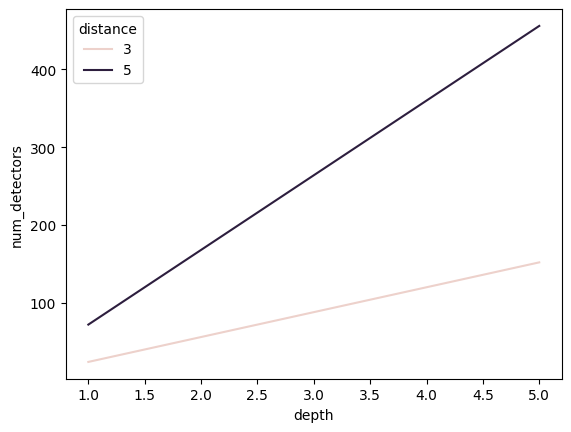

In [199]:
sns.lineplot(df_cir4, x='depth', y='num_detectors', hue='distance')

## MCCD's Dataset

In [176]:
depth_list = [1,2,3,4,5]
d_list = [3]
c_list = [3, 4]
record_list = []

for depth, d, c in itertools.product(depth_list, d_list, c_list):
    dataset = CachedSyndromeDataset('./cached_qec_data_small/train', code_distance=d,
                                   circuit_index=str(c), batch_size=1024, depth=depth)
    data = dataset[0]
    final_syndromes = data['final_round_syndromes']
    syndromes = data['syndromes']
    num_detectors = (syndromes.numel() + final_syndromes.numel())// syndromes.shape[0]
    record_list.append(dict(
        depth=depth,
        d=d,
        c=c,
        timesteps=syndromes.shape[1],
        nbits=data['syndromes'].shape[2],
        ndets=data['syndromes'].shape[3],
        frs=final_syndromes.shape,
        num_detectors=num_detectors,
    ))

df_record = pd.DataFrame.from_records(record_list).sort_values('c')

In [177]:
df_record

,depth,d,c,timesteps,nbits,ndets,frs,num_detectors
0,1,3,3,2,2,8,"(1024, 2, 4)",40
2,2,3,3,4,2,8,"(1024, 2, 4)",72
4,3,3,3,6,2,8,"(1024, 2, 4)",104
6,4,3,3,8,2,8,"(1024, 2, 4)",136
8,5,3,3,10,2,8,"(1024, 2, 4)",168
1,1,3,4,4,2,8,"(1024, 2, 4)",72
3,2,3,4,8,2,8,"(1024, 2, 4)",136
5,3,3,4,12,2,8,"(1024, 2, 4)",200
7,4,3,4,16,2,8,"(1024, 2, 4)",264
9,5,3,4,20,2,8,"(1024, 2, 4)",328


In [179]:
k, b = np.polyfit(df_record[df_record.c == 3]['depth'], df_record[df_record.c == 3]['num_detectors'], 1)
k, b

(np.float64(32.00000000000001), np.float64(7.999999999999954))

In [181]:
k, b = np.polyfit(df_record[df_record.c == 4]['depth'], df_record[df_record.c == 4]['num_detectors'], 1)
k, b

(np.float64(64.0), np.float64(7.999999999999871))

<Axes: xlabel='depth', ylabel='num_detectors'>

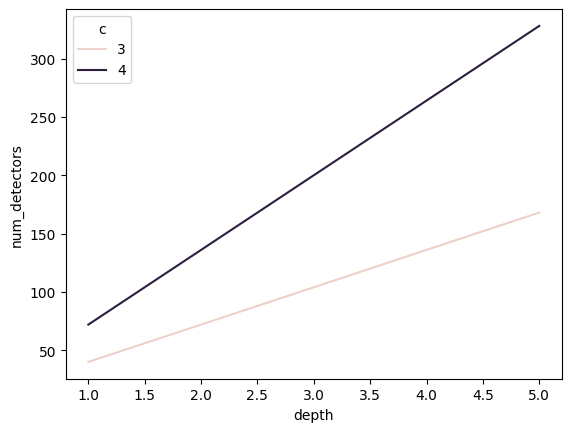

In [178]:
sns.lineplot(df_record, x='depth', y='num_detectors', hue='c')

For c=3, timesteps = 2 * depth

For c=4, timesteps = 4 * depth

ndets is d^2 - 1, 8 for d=3

nbits is always 2 for c=3 and c=4

num_detectors = timesteps * nbits * ndets

final-round-symdrone = nbits * (d^2 - 1)